### Predict TTC delays by creating a machine learning model in Python

We will import ttc data into a Jupyter notebook and use Pandas to clean it. Then, build a machine learning model with Scikit-Learn and use Matplotlib to visualize output.

### 1. Add Liberaries


In [1]:
import pandas as pd
import glob
import requests
import urllib, json
import warnings
warnings.filterwarnings("ignore")

### 2. Read and explore the dataset

 Load ttc_data.xlsx, create a Pandas DataFrame from it, and display the first five rows.

In [2]:
#Read and explore the dataset
%time
ttc_df = pd.read_excel("ttc_data.xlsx")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [3]:
ttc_df.head()

,Unnamed: 0,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


One of the first things we typically want to know about a dataset is how many rows it contains. We can get the count the dataset.


In [4]:
ttc_df.shape

(112513, 11)

In [5]:
list(ttc_df.columns.values) 

['Unnamed: 0',
 'Date',
 'Time',
 'Day',
 'Station',
 'Code',
 'Min Delay',
 'Min Gap',
 'Bound',
 'Line',
 'Vehicle']

Here is the complete list of columns in the dataset

### Data Dictionary
    - Date	     Date (YYYY/MM/DD)	                              12/31/16
    - Time	     Time (24h clock)	                               1:59
    - Day	      Name of the day of the week	                    Saturday 
    - Station	  TTC subway station name	                        Rosedale Station
    - Code	     TTC delay code	                                 MUIS
    - Min Delay	Delay (in minutes) to subway service	           5 
    - Min Gap	  Time length (in minutes) between trains	        9
    - Bound	    Direction of train dependant on the line	       N
    - Line	     TTC subway line i.e.  YU, BD, SHP, and SRT	     YU
    - Vehicle	  TTC train number	                               5961

### 3. Feature Engineering 

After exploration we can add more features to this dataset. Following is the list of features we will add:

- Separate the Bounds (East, West,North,South)
- Separate Weekend Delays (Weekend Sat, Weend Sun)
- Isolating the month, year, and day of the week as separate features (Day,Month,Year)
- Add City Column to the dataset
- Get part of the day (Morning, Afternoon, Evening,Night)
- Addt Hour and Minute column from Timestamp
- Add latitude and longitude (lat,lon)

In [8]:
#Separate bounds
ttc_df["East Bound"] = ttc_df["Bound"] == 'E'
ttc_df["West Bound"] = ttc_df["Bound"] == 'W'
ttc_df["North Bound"] = ttc_df["Bound"] == 'N'
ttc_df["South Bound"] = ttc_df["Bound"] == 'S'

# Separate Weekend Delays
ttc_df["Weekend-Sat"] = ttc_df["Day"] == 'Saturday'
ttc_df["Weekend-Sun"] = ttc_df["Day"] == 'Sunday'

#Isolating the month, year, and day of the week as separate predictors
#The numeric day of the year (ignoring the calendar year)
#if there were a seasonal component to these data, and it appears
#that there is, then the numeric day of the year would be best. Also, if some
#months showed higher success rates than others those should be taken into further EDA
#the month is preferable.

ttc_df['Year'] = pd.DatetimeIndex(ttc_df['Date']).year
ttc_df['Month'] = pd.DatetimeIndex(ttc_df['Date']).month
ttc_df['Day'] = pd.DatetimeIndex(ttc_df['Date']).day

#add city column
ttc_df['City'] = 'Toronto'
#ttc_df

In [9]:

ttc_df['Station_Location'] = ttc_df['Station'] + ' ' + ttc_df['City']
#ttc_df['Station_Location']


In [10]:
ttc_df.head()

,Unnamed: 0,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,...,East Bound,West Bound,North Bound,South Bound,Weekend-Sat,Weekend-Sun,Year,Month,City,Station_Location
0,0,2014-01-01,00:21,1,VICTORIA PARK STATION,MUPR1,55,60,W,BD,...,False,True,False,False,False,False,2014,1,Toronto,VICTORIA PARK STATION Toronto
1,1,2014-01-01,02:06,1,HIGH PARK STATION,SUDP,3,7,W,BD,...,False,True,False,False,False,False,2014,1,Toronto,HIGH PARK STATION Toronto
2,2,2014-01-01,02:40,1,SHEPPARD STATION,MUNCA,0,0,NaN,YU,...,False,False,False,False,False,False,2014,1,Toronto,SHEPPARD STATION Toronto
3,3,2014-01-01,03:10,1,LANSDOWNE STATION,SUDP,3,8,W,BD,...,False,True,False,False,False,False,2014,1,Toronto,LANSDOWNE STATION Toronto
4,4,2014-01-01,03:20,1,BLOOR STATION,MUSAN,5,10,S,YU,...,False,False,False,True,False,False,2014,1,Toronto,BLOOR STATION Toronto


In [11]:
ttc_df[['Hour','Minute']] = ttc_df['Time'].astype(str).str.split(':', expand=True).astype(int)
#ttc_df

In [12]:
#Craete a function to get part of the day(morning, noon,afternoon evening and night) from Timestamp
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'
    

In [13]:
ttc_df['Time-only'] = ttc_df['Hour'].apply(f)
#ttc_df['Time-only']

In [14]:
len(ttc_df['Station'].unique())

464

In [ ]:
#Get the list of all stations in dataset
#stations = list(ttc_df['Station'].unique())
#stations


In [15]:
address_list_1 = ttc_df['Station_Location'].values

In [16]:
address_list_1


array(['VICTORIA PARK STATION Toronto', 'HIGH PARK STATION Toronto',
       'SHEPPARD STATION Toronto', ..., 'GREENWOOD STATION Toronto',
       'YUS/BD/SEPPARD SUBWAY Toronto', 'BLOOR DANFORTH SUBWAY Toronto'],
      dtype=object)

In [17]:
ttc_df.head()

,Unnamed: 0,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,...,South Bound,Weekend-Sat,Weekend-Sun,Year,Month,City,Station_Location,Hour,Minute,Time-only
0,0,2014-01-01,00:21,1,VICTORIA PARK STATION,MUPR1,55,60,W,BD,...,False,False,False,2014,1,Toronto,VICTORIA PARK STATION Toronto,0,21,Late Night
1,1,2014-01-01,02:06,1,HIGH PARK STATION,SUDP,3,7,W,BD,...,False,False,False,2014,1,Toronto,HIGH PARK STATION Toronto,2,6,Late Night
2,2,2014-01-01,02:40,1,SHEPPARD STATION,MUNCA,0,0,NaN,YU,...,False,False,False,2014,1,Toronto,SHEPPARD STATION Toronto,2,40,Late Night
3,3,2014-01-01,03:10,1,LANSDOWNE STATION,SUDP,3,8,W,BD,...,False,False,False,2014,1,Toronto,LANSDOWNE STATION Toronto,3,10,Late Night
4,4,2014-01-01,03:20,1,BLOOR STATION,MUSAN,5,10,S,YU,...,True,False,False,2014,1,Toronto,BLOOR STATION Toronto,3,20,Late Night


In [18]:
ttc_df.isnull().sum()

Unnamed: 0              0
Date                    0
Time                    0
Day                     0
Station                 0
Code                    1
Min Delay               0
Min Gap                 0
Bound               24406
Line                  438
Vehicle                 0
East Bound              0
West Bound              0
North Bound             0
South Bound             0
Weekend-Sat             0
Weekend-Sun             0
Year                    0
Month                   0
City                    0
Station_Location        0
Hour                    0
Minute                  0
Time-only               0
dtype: int64

In [19]:
ttc_df = ttc_df[['Year', 'Month','Day','Hour','Minute', 'Time-only','Min Delay', 'Min Gap', 'Vehicle',
                 'East Bound', 'West Bound', 'North Bound', 'South Bound',
                 'Weekend-Sat', 'Weekend-Sun', 
                 'Code','Line',       
                 'City', 'Station_Location'
                   ]]  

In [20]:
#ttc_df['West Bound'] = ttc_df['West Bound'].map({"True": 1, "False": 0})
#ttc_df['East Bound'] = ttc_df['East Bound'].replace(to_replace = "True", value = 1)
ttc_df[['East Bound']] = ttc_df[['East Bound']].astype('int')
ttc_df[['West Bound']] = ttc_df[['West Bound']].astype('int')
ttc_df[['North Bound']] = ttc_df[['North Bound']].astype('int')
ttc_df[['South Bound']] = ttc_df[['South Bound']].astype('int')
ttc_df[['Weekend-Sat']] = ttc_df[['Weekend-Sat']].astype('int')
ttc_df[['Weekend-Sun']] = ttc_df[['Weekend-Sun']].astype('int')

In [21]:
ttc_df.head()


,Year,Month,Day,Hour,Minute,Time-only,Min Delay,Min Gap,Vehicle,East Bound,West Bound,North Bound,South Bound,Weekend-Sat,Weekend-Sun,Code,Line,City,Station_Location
0,2014,1,1,0,21,Late Night,55,60,5111,0,1,0,0,0,0,MUPR1,BD,Toronto,VICTORIA PARK STATION Toronto
1,2014,1,1,2,6,Late Night,3,7,5001,0,1,0,0,0,0,SUDP,BD,Toronto,HIGH PARK STATION Toronto
2,2014,1,1,2,40,Late Night,0,0,0,0,0,0,0,0,0,MUNCA,YU,Toronto,SHEPPARD STATION Toronto
3,2014,1,1,3,10,Late Night,3,8,5116,0,1,0,0,0,0,SUDP,BD,Toronto,LANSDOWNE STATION Toronto
4,2014,1,1,3,20,Late Night,5,10,5386,0,0,0,1,0,0,MUSAN,YU,Toronto,BLOOR STATION Toronto


In [22]:
ttc_df_line = ttc_df['Line'].values
print(ttc_df_line)

['BD' 'BD' 'YU' ... 'BD' 'YU/BD' 'BD']


In [23]:
ttc_df['Time-range']=len(ttc_df['Time-only'].unique())

#ttc_df['Time-range']= ttc_df['Time-only'].values
Time_range = ttc_df['Time-only'].values
#Early Morning, Morning, Noon, Evening, Night,Late Night

In [24]:
def f(x):
    if (x > 4) and (x <= 8):
        return 1 
    elif (x > 8) and (x <= 12 ):
        return 2 
    elif (x > 12) and (x <= 16):
        return 3
    elif (x > 16) and (x <= 20) :
        return 4 
    elif (x > 20) and (x <= 24):
        return 5 
    elif (x <= 4):
        return 6 

In [25]:
#Intervals of the day
ttc_df['Day-Half'] = ttc_df['Hour'].apply(f)
ttc_df.head()

,Year,Month,Day,Hour,Minute,Time-only,Min Delay,Min Gap,Vehicle,East Bound,...,North Bound,South Bound,Weekend-Sat,Weekend-Sun,Code,Line,City,Station_Location,Time-range,Day-Half
0,2014,1,1,0,21,Late Night,55,60,5111,0,...,0,0,0,0,MUPR1,BD,Toronto,VICTORIA PARK STATION Toronto,6,6
1,2014,1,1,2,6,Late Night,3,7,5001,0,...,0,0,0,0,SUDP,BD,Toronto,HIGH PARK STATION Toronto,6,6
2,2014,1,1,2,40,Late Night,0,0,0,0,...,0,0,0,0,MUNCA,YU,Toronto,SHEPPARD STATION Toronto,6,6
3,2014,1,1,3,10,Late Night,3,8,5116,0,...,0,0,0,0,SUDP,BD,Toronto,LANSDOWNE STATION Toronto,6,6
4,2014,1,1,3,20,Late Night,5,10,5386,0,...,0,1,0,0,MUSAN,YU,Toronto,BLOOR STATION Toronto,6,6


In [27]:
# Reselect the subset of data
ttc_df = ttc_df[['Year', 'Month','Day','Hour','Minute', 'Day-Half','Min Delay', 'Min Gap', 'Vehicle',
                 'East Bound', 'West Bound', 'North Bound', 'South Bound',
                 'Weekend-Sat', 'Weekend-Sun', 'Station_Location',
                   ]] 

In [28]:
ttc_df.head()

,Year,Month,Day,Hour,Minute,Day-Half,Min Delay,Min Gap,Vehicle,East Bound,West Bound,North Bound,South Bound,Weekend-Sat,Weekend-Sun,Station_Location
0,2014,1,1,0,21,6,55,60,5111,0,1,0,0,0,0,VICTORIA PARK STATION Toronto
1,2014,1,1,2,6,6,3,7,5001,0,1,0,0,0,0,HIGH PARK STATION Toronto
2,2014,1,1,2,40,6,0,0,0,0,0,0,0,0,0,SHEPPARD STATION Toronto
3,2014,1,1,3,10,6,3,8,5116,0,1,0,0,0,0,LANSDOWNE STATION Toronto
4,2014,1,1,3,20,6,5,10,5386,0,0,0,1,0,0,BLOOR STATION Toronto


In [29]:
from sklearn.preprocessing import LabelEncoder

lb_station = LabelEncoder()
ttc_df["station_code"] = lb_station.fit_transform(ttc_df["Station_Location"])
ttc_df[["Station_Location", "station_code"]].head(11)

,Station_Location,station_code
0,VICTORIA PARK STATION Toronto,382
1,HIGH PARK STATION Toronto,154
2,SHEPPARD STATION Toronto,299
3,LANSDOWNE STATION Toronto,216
4,BLOOR STATION Toronto,20
5,DUFFERIN STATION Toronto,78
6,NORTH YORK CTR STATION Toronto,252
7,SHEPPARD STATION Toronto,299
8,QUEEN STATION Toronto,273
9,RUNNYMEDE STATION Toronto,285


In [30]:
#ttc_df
# using list comprehension to create delay column conditionally
ttc_df['Delay'] = [1 if x != 0 else 0 for x in ttc_df['Min Delay']]

In [31]:
ttc_df.head()

,Year,Month,Day,Hour,Minute,Day-Half,Min Delay,Min Gap,Vehicle,East Bound,West Bound,North Bound,South Bound,Weekend-Sat,Weekend-Sun,Station_Location,station_code,Delay
0,2014,1,1,0,21,6,55,60,5111,0,1,0,0,0,0,VICTORIA PARK STATION Toronto,382,1
1,2014,1,1,2,6,6,3,7,5001,0,1,0,0,0,0,HIGH PARK STATION Toronto,154,1
2,2014,1,1,2,40,6,0,0,0,0,0,0,0,0,0,SHEPPARD STATION Toronto,299,0
3,2014,1,1,3,10,6,3,8,5116,0,1,0,0,0,0,LANSDOWNE STATION Toronto,216,1
4,2014,1,1,3,20,6,5,10,5386,0,0,0,1,0,0,BLOOR STATION Toronto,20,1


In [32]:
ttc_df = ttc_df[['Year', 'Month','Day','Hour','Minute', 'Day-Half',  
                 'East Bound', 'West Bound', 'North Bound', 'South Bound',
                 'Weekend-Sat', 'Weekend-Sun', 'station_code', 'Delay'
                   ]] 

In [33]:
ttc_df.head()
#Delay =len(ttc_df['Min Delay'].unique())
#Delay
#ttc_df['Time-range']= ttc_df['Time-only'].values
#Time_range = ttc_df['Time-only'].values

,Year,Month,Day,Hour,Minute,Day-Half,East Bound,West Bound,North Bound,South Bound,Weekend-Sat,Weekend-Sun,station_code,Delay
0,2014,1,1,0,21,6,0,1,0,0,0,0,382,1
1,2014,1,1,2,6,6,0,1,0,0,0,0,154,1
2,2014,1,1,2,40,6,0,0,0,0,0,0,299,0
3,2014,1,1,3,10,6,0,1,0,0,0,0,216,1
4,2014,1,1,3,20,6,0,0,0,1,0,0,20,1


## Split/Train Data

To create a machine learning model, we need two datasets: one for training and one for testing.We will perform an 80-20 split on the DataFrame we prepared to train a machine learning model. 

We will also separate the DataFrame into feature columns and label columns. The former contains the columns used as input to the model while the latter contains the column that the model will attempt to predict — in this case, the Delay column, which indicates whether train will arrive on time.

In [35]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split( ttc_df.drop('Delay', axis=1), ttc_df['Delay'], test_size=0.2, random_state=42)

- The first statement imports scikit-learn's train_test_split helper function.

- The second line uses the function to split the DataFrame into a training set containing 80% of the original data, and a test set containing the remaining 20%. 

- The random_state parameter seeds the random-number generator used to do the splitting, while the first and second parameters are DataFrames containing the feature columns and the label column.

In [36]:
train_x.shape

(90010, 13)

In [37]:
test_x.shape

(22503, 13)

Our model will be a binary classification model that predicts whether a train will arrive on-time or late ("binary" because there are only two possible outputs).

Using scikit-learn we don't have to build these models — or implement the algorithms that they use — by hand. Scikit-learn includes a variety of classes for implementing common machine learning models. One of them is RandomForestClassifier, which fits multiple decision trees to the data and uses averaging to boost the overall accuracy and limit overfitting.

We will create a RandomForestClassifier object and train it by calling the fit method.

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

The output shows the parameters used in the classifier, including n_estimators, which specifies the number of trees in each decision-tree forest, and max_depth, which specifies the maximum depth of the decision trees. The values shown are the defaults, but we can override any of them when creating the RandomForestClassifier object.

We can tune the model for better accuracy results in the Hyperparameter tuning phase of this project.

In [39]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.7117273252455228

### Test the Model

The mean accuracy is 71%, which seems not so good on the surface. However, mean accuracy isn't always a reliable indicator of the accuracy of a classification model. Let's dig a little deeper and determine how accurate the model really is — that is, how adept it is at determining whether a flight will arrive on time.


There are several ways to measure the accuracy of a classification model. One of the best overall measures for a binary classification model is Area Under Receiver Operating Characteristic Curve (sometimes referred to as "ROC AUC"), which essentially quantifies how often the model will make a correct prediction regardless of the outcome. 

1. Before computing the ROC AUC, we must generate prediction probabilities for the test set. These probabilities are estimates for each of the classes, or answers, the model can predict. For example, [0.88199435, 0.11800565] means that there's an 89% chance that a train will arrive on time (Delay = 0) and a 12% chance that it won't (Delay = 1). The sum of the two probabilities adds up to 100%.

In [48]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

2. Now using the following statement we will generate an ROC AUC score from the probabilities using scikit-learn's

In [49]:
roc_auc_score(test_y, probabilities[:, 1])

0.7261837467113406

ROC AUC takes this into account and provides a more accurate indication of how likely it is that a prediction of on-time or late will be correct.

3. We can further investigate model's behavior by generating a confusion matrix, also known as an error matrix. The confusion matrix quantifies the number of times each answer was classified correctly or incorrectly. Specifically, it quantifies the number of false positives, false negatives, true positives, and true negatives.

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[14086,  1761],
       [ 4726,  1930]])

4. Other measures of accuracy for a classification model include precision and recall. Suppose the model was presented with three on-time arrivals and three delayed arrivals, and that it correctly predicted two of the on-time arrivals, but incorrectly predicted that two of the delayed arrivals would be on time. 

Scikit-learn contains a handy method named precision_score for computing precision and recall_score for recall computation. To quantify the precision and recall of our model we will use scikit-learn's recall_score and precision_score method.

In [51]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.9462596570567176

In [43]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9961121910580394

### Visualize Output of Model

We'll import Matplotlib into the notebook and configure the notebook to support inline Matplotlib output.

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

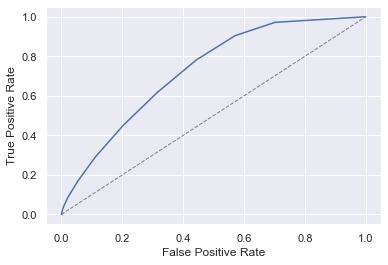

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The dotted line in the middle of the graph represents a 50-50 chance of obtaining a correct answer. The blue curve represents the accuracy of our model.

The reason you built a machine-learning model is to predict whether a train will arrive on time or late. Now we will write a Python function that calls the machine-learning model that we built to compute the likelihood that train will be on time. Then we'll use the function to analyze different ttc arrivals.